## Imports

In [1]:
import keras
import numpy as np

import time

import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl

# import misc

import pandas as pd

import datetime

import glob

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras import utils

import keras
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Conv1D, MaxPooling1D, Flatten, \
                                    Masking, LSTM, Softmax, Multiply, Layer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Concatenate
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.model_selection import train_test_split

2025-01-21 04:09:24.873606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737461364.892676   50790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737461364.898580   50790 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 04:09:24.918436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Declare Datasets

## Declare Sub-Models

### Visual Embedder (VGG-16)

In [2]:
def build_visual_embedder():
    # Load the VGG16 model without the top layers
    visual_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model to retain pretrained weights during training
    visual_base_model.trainable = False

    # Add a top for 3-way classification
    x = visual_base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization

    visual_base_features = Dense(16, activation='relu')(x) 

    # Define the final model
    visual_model = Model(inputs=visual_base_model.input, outputs=visual_base_features, name="VisualEmbedder")
    return visual_model

### Demographic Embedder

In [3]:
def build_demographics_embedder():
    # Input layer for demographics data
    input_layer = Input(shape=(27, ), name="demographics_input")

    x = Dense(64, activation='relu')(input_layer)
    x = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    
    # Classification head
    demographics_base_features = Dense(16, activation='relu')(x)
    
    # Define the model
    demographics_model = Model(inputs=input_layer, outputs=demographics_base_features, name="DemographicsEmbedder")
    return demographics_model

### Time-Series Embedder

In [4]:
max_seq_length = 6

In [5]:
def build_time_embedder():
    # Input layer for time series data (4 input variables)
    time_series_input = Input(shape=(max_seq_length, 4), name="time_series_input")
    masked_input = Masking(mask_value=0.0)(time_series_input)

    # Use the last hidden state
    x = LSTM(32, return_sequences=False)(masked_input)

    # Dense layer to create time series output
    time_base_features = Dense(16, activation="relu")(x)
    
    # Define the model
    time_model = Model(inputs=time_series_input, outputs=time_base_features, name="TimeSeriesEmbedder")
    return time_model

#### Bad LSTM? (Attention doesn't work :/)

In [6]:
class BroadcastLayer(Layer):
    def call(self, inputs):
        attention_weights, lstm_output = inputs
        return tf.broadcast_to(attention_weights, tf.shape(lstm_output))
    
class ReduceSumLayer(Layer):
    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)

In [7]:
def bad_build_time_embedder():
    # Input layer for time series data (4 input variables)
    time_series_input = Input(shape=(max_seq_length, 4), name="time_series_input")
    masked_input = Masking(mask_value=0.0)(time_series_input)

    # Time-distributed output
    lstm_output = LSTM(64, return_sequences=True)(masked_input)

    # Attention mechanism
    attention_scores = Dense(6, activation="tanh")(lstm_output)  # Shape: (batch_size, time_steps, 1)
    attention_weights = Softmax(axis=1)(attention_scores)        # Shape: (batch_size, time_steps, 1)

    # Project attention_weights to match lstm_output shape
    attention_weights = Dense(64, activation=None)(attention_weights)  # Shape: (batch_size, time_steps, hidden_units)

    # # Broadcasting Attention Weights
    # broadcast_layer = BroadcastLayer()
    # attention_weights = broadcast_layer([attention_weights, lstm_output])  # Shape: (batch_size, time_steps, hidden_units)

    # Element-wise Multiplication
    context_vector = Multiply()([lstm_output, attention_weights])  # Shape: (batch_size, time_steps, hidden_units)

    # Reduce Sum over Time Steps
    reduce_sum_layer = ReduceSumLayer()
    context_vector = reduce_sum_layer(context_vector)  # Shape: (batch_size, hidden_units)

    # Dense layer to create time series output
    time_base_features = Dense(16, activation="relu")(context_vector)
    
    # Define the model
    time_model = Model(inputs=time_series_input, outputs=time_base_features, name="TimeSeriesEmbedder")
    return time_model

## Joint Model

In [8]:
# Visual embedder
visual_embedder = build_visual_embedder()

# Demographics embedder
demographics_embedder = build_demographics_embedder()

# Time Series Embedder
time_embedder = build_time_embedder()

# Combine both embedders
combined_input = Concatenate()([visual_embedder.output, demographics_embedder.output, time_embedder.output])

# Add final classification layers
x = Dense(128, activation='relu')(combined_input)
# x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
# x = Dropout(0.5)(x)
final_output = Dense(3, activation='softmax', name="final_output")(x)

# Define the combined model
combined_model = Model(inputs=[visual_embedder.input, demographics_embedder.input, time_embedder.input], 
                       outputs=final_output, name="CombinedModel")

2025-01-21 04:09:27.562668: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2025-01-21 04:09:27.562712: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: rts-clpw-wen
2025-01-21 04:09:27.562722: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: rts-clpw-wen
2025-01-21 04:09:27.562819: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 525.60.13
2025-01-21 04:09:27.562874: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 460.80.0
2025-01-21 04:09:27.562883: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:262] kernel version 460.80.0 does not match DSO version 525.60.13 -- cannot find working

#### Joint-Model Structure

In [9]:
combined_model.summary()

Model: "CombinedModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,399,827 (58.75 MB)

 Trainable params: 685,139 (2.61 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Train Joint-Model

#### Load Data

In [10]:
# Mapping for string labels to integers
label_mapping = {"CN": 0, "MCI": 1, "Dementia": 2}

In [11]:
manifest = pd.read_csv("/home/mason/TFN_AD/AD_Patient_Manifest.csv")


In [12]:
# Load all data into memory. Not elegant, but works.
def load_all_data(manifest, target_size=(224, 224), time_series_columns=None, label_mapping=None):
    image_data = []
    demographics_data = []
    time_series_data = []
    labels = []
    label_mapping = label_mapping or {}

    for _, row in manifest.iterrows():
        patient_path = row["path"]
        patient_df = pd.read_pickle(patient_path)

        # Load image data
        image_paths = [patient_df['image_path'].iloc[0]]
        for path in image_paths:
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            image_data.append(img_array)

        # Load demographics data
        demographics = patient_df['one_hot_vector'].iloc[0]
        demographics = np.array(demographics).reshape(27, 1)
        demographics_data.append(demographics)

        # Process time series data
        if time_series_columns is None:
            raise ValueError("Please specify the time series columns.")
        
        # Extract the relevant time series columns
        time_series = patient_df[time_series_columns].values  # Extract as NumPy array

        # Truncate or pad to max_seq_length
        if len(time_series) > max_seq_length:
            time_series = time_series[:max_seq_length, :]
        elif len(time_series) < max_seq_length:
            padding = np.zeros((max_seq_length - len(time_series), len(time_series_columns)))
            time_series = np.vstack([time_series, padding])
        time_series_data.append(time_series)

        # Load labels
        label_str = patient_df['DX'].iloc[0]
        label_int = label_mapping[label_str]
        labels.append(label_int)

    # Convert to numpy arrays
    image_data = np.array(image_data, dtype=np.float32)
    demographics_data = np.array(demographics_data, dtype=np.float32)
    time_series_data = np.array(time_series_data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return image_data, demographics_data, time_series_data, labels

In [13]:
# Time series variables to extract
time_series_columns = ['Years_bl', 'ADAS11', 'ADAS13', 'ADASQ4']

# Load all data into memory
image_data, demographics_data, time_series_data, labels = load_all_data(manifest, target_size=(224, 224), 
                                                      time_series_columns=time_series_columns, label_mapping=label_mapping)

# Split the data
test_size = 0.2  # 20% of the data for testing

(image_train, image_test,
 demographics_train, demographics_test,
 time_train, time_test,
 labels_train, labels_test) = train_test_split(
    image_data, demographics_data, time_series_data, labels, test_size=test_size, random_state=42, stratify=labels
)

In [14]:
batch_size = 64

# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((image_train, demographics_train, time_train), labels_train))
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create testing (validation) dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((image_test, demographics_test, time_test), labels_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
print(f"Image train shape: {image_train.shape}")
print(f"Demographics train shape: {demographics_train.shape}")
print(f"Time train shape: {time_train.shape}")
print(f"Labels train shape: {labels_train.shape}")

Image train shape: (305, 224, 224, 3)
Demographics train shape: (305, 27, 1)
Time train shape: (305, 6, 4)
Labels train shape: (305,)



#### Train the Model

In [16]:
# Compile the model
combined_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [17]:
print("Model inputs:", combined_model.input)

Model inputs: [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>, <KerasTensor shape=(None, 27), dtype=float32, sparse=False, name=demographics_input>, <KerasTensor shape=(None, 6, 4), dtype=float32, sparse=False, name=time_series_input>]


In [18]:
# Early stopping to prevent redundant training.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

In [19]:
# Train the model
history = combined_model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30


/home/mason/.conda/envs/LOSresearch/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'demographics_input', 'time_series_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2647 - loss: 1.3405 - val_accuracy: 0.2468 - val_loss: 1.1470
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2447 - loss: 1.1663 - val_accuracy: 0.2338 - val_loss: 1.1202
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2672 - loss: 1.1211 - val_accuracy: 0.2857 - val_loss: 1.1101
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2974 - loss: 1.1073 - val_accuracy: 0.2597 - val_loss: 1.1059
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2813 - loss: 1.1036 - val_accuracy: 0.1818 - val_loss: 1.0964
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2828 - loss: 1.0828 - val_accuracy: 0.2987 - val_loss: 1.0806
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3306 - loss: 1.0918 - val_accuracy: 0.3896 - val_loss: 1.0687
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3692 - loss: 1.0783 - val_accuracy: 0.3896 - val_loss: 1.0598
Epoch 9/30
5/5 ━━━━━━━━━━━

#### Visualize Training Performance

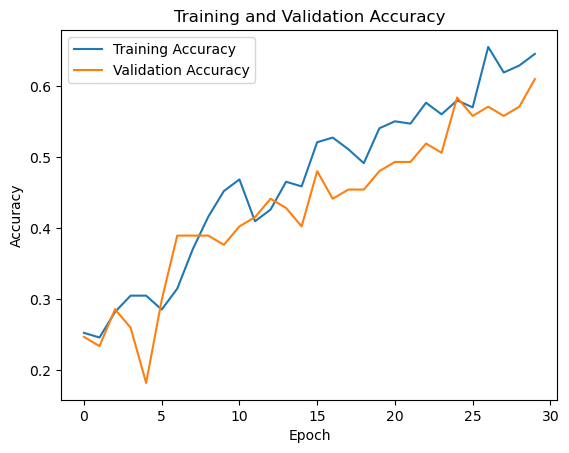

In [20]:
# Get training and validation accuracy and loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

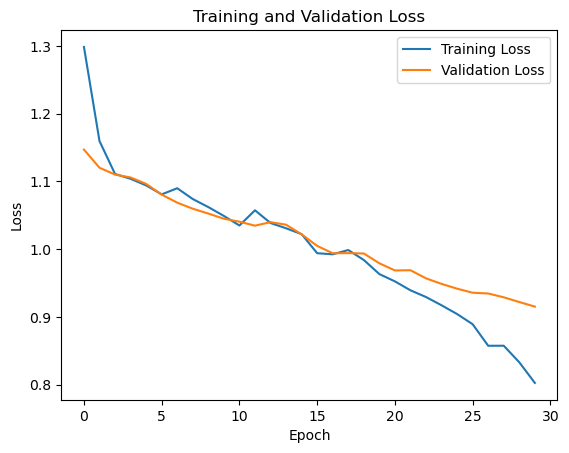

In [21]:
# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [22]:
# Get the final accuracy and loss for the last epoch
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)

Final Training Accuracy: 0.645901620388031
Final Validation Accuracy: 0.6103895902633667
Final Training Loss: 0.8027445077896118
Final Validation Loss: 0.9153481721878052
